### Introduction

Each bag contains a fixed number of MNIST digits (e.g., 5). The label is a sum of digits in the bag. The task is to predict the sum of digits and the weights of contribution of each digit. Perfectly, the bigger the digit is, the higher the predicted weight it should have.

**Instance:** One MNIST digit image.

**Bag**: A collection of digits (e.g., a list of 5 MNIST digits).

**Label:** A sum of digits in the bag.

**Key instance:** All digits.

In [1]:
import logging
import warnings
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)

import time
import torch
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# MNIST dataset creation
from milearn.data.mnist import load_mnist, create_bags_or, create_bags_and, create_bags_xor, create_bags_reg

# Preprocessing
from milearn.preprocessing import BagMinMaxScaler

# Network hparams
from milearn.network.module.hopt import DEFAULT_PARAM_GRID

# MIL wrappers
from milearn.network.regressor import BagWrapperMLPNetworkRegressor, InstanceWrapperMLPNetworkRegressor
from milearn.network.classifier import BagWrapperMLPNetworkClassifier, InstanceWrapperMLPNetworkClassifier

# MIL networks
from milearn.network.regressor import (InstanceNetworkRegressor,
                                       BagNetworkRegressor,
                                       AdditiveAttentionNetworkRegressor,
                                       SelfAttentionNetworkRegressor,
                                       HopfieldAttentionNetworkRegressor,
                                       DynamicPoolingNetworkRegressor)

# Utils
from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

# Prediction visualisation
from milearn.data.mnist import visualize_bag_with_weights

### Key Instance Detection Ranking Accuracy for Regression

This function evaluates how well a model's predicted attention weights rank the important instances in a bag, by computing the Spearman rank correlation between:

* The true importance ranking (represented here by the digit values)

* The predicted importance scores (attention weights)

In [2]:
def kid_ranking_accuracy(instance_digits, attn_weights):

    per_bag_corrs = []
    for w, digits in zip(attn_weights, instance_digits):
        if len(set(digits)) == 1:
            # Avoid undefined correlation when all digits are identical
            per_bag_corrs.append(0.0)
            continue

        corr, _ = spearmanr(w, digits)
        if np.isnan(corr):
            corr = 0.0
        per_bag_corrs.append(corr)

    mean_corr = np.mean(per_bag_corrs)
    return mean_corr

### 1. Create MNIST dataset

In [3]:
bag_size = 10
num_bags = 10000

data, targets = load_mnist()
bags, labels, key = create_bags_reg(data, targets, bag_size=bag_size, num_bags=num_bags, bag_agg="mean", random_state=42)

In [4]:
# digit values
key[0]

[7, 3, 8, 9, 3, 9, 7, 7, 5, 4]

### 2. Build model

In [5]:
# train/test split
x_train, x_test, y_train, y_test, key_train, key_test = train_test_split(bags, labels, key, random_state=42)

# features scaling
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [6]:
model = DynamicPoolingNetworkRegressor()
# model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=True)
model.fit(x_train_scaled, y_train)

DynamicPoolingNetworkRegressor(
  (instance_transformer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): GELU(approximate='none')
  )
  (bag_estimator): Norm()
  (dynamic_pooling): DynamicPooling()
)

In [7]:
y_pred = model.predict(x_test_scaled)
w_pred = model.get_instance_weights(x_test_scaled)
w_pred = [w.flatten() for w in w_pred]

In [8]:
print(f"Regression R2: {r2_score(y_test, y_pred):.2f}")
print(f"KID ranking accuracy: {kid_ranking_accuracy(key_test, w_pred):.2f}")

Regression R2: 0.78
KID ranking accuracy: 0.85


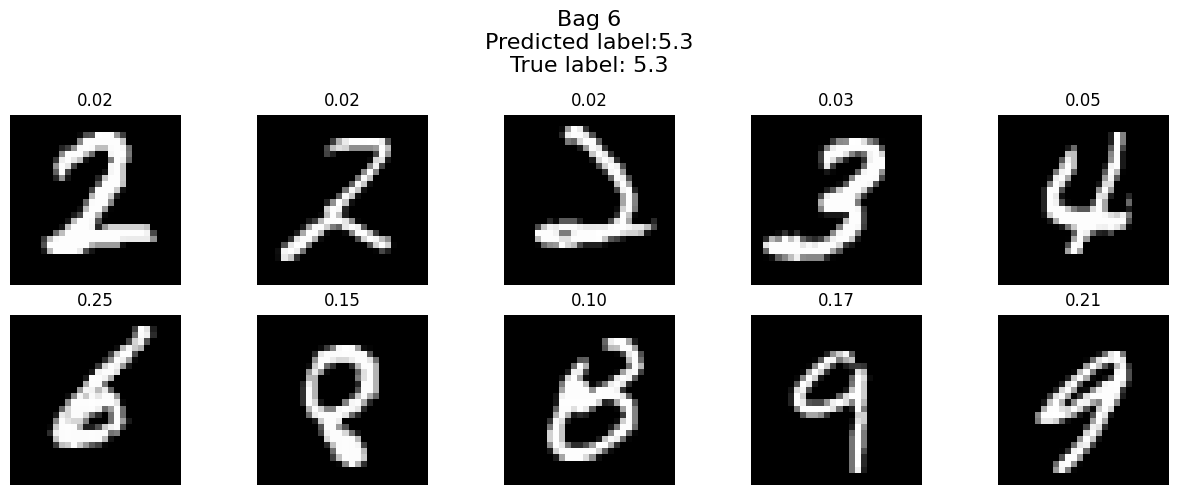

In [9]:
N = 6
visualize_bag_with_weights(x_test[N], w_pred[N], digits=key_test[N], sort=True, 
                           title=f"Bag {N}\nPredicted label:{y_pred[N].item():.1f}\nTrue label: {y_test[N]}")

### 3. Mini-benchmark

In [10]:
regressor_list = [
    
        # attention mil networks
        ("AdditiveAttentionNetworkRegressor", AdditiveAttentionNetworkRegressor()),
        ("SelfAttentionNetworkRegressor", SelfAttentionNetworkRegressor()),
        ("HopfieldAttentionNetworkRegressor", HopfieldAttentionNetworkRegressor()),

        # other mil networks
        ("DynamicPoolingNetworkRegressor", DynamicPoolingNetworkRegressor()),
    ]

In [13]:
bag_size = 10
num_bags = 10000

# create data
data, targets = load_mnist()
bags, labels, key = create_bags_reg(data, targets, bag_size=bag_size, bag_agg="mean", num_bags=num_bags)
x_train, x_test, y_train, y_test, key_train, key_test = train_test_split(bags, labels, key, random_state=42)

# scale features
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled, x_test_scaled = scaler.transform(x_train), scaler.transform(x_test)

# build models
res_df = pd.DataFrame()
for model_idx, (name, model) in enumerate(regressor_list, 1):
    print(f"  [Model {model_idx}/{len(regressor_list)}] Training model: '{name}'")

    # train model
    # model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=False)
    model.fit(x_train_scaled, y_train)
    # predict
    y_pred = model.predict(x_test_scaled)
    w_pred = model.get_instance_weights(x_test_scaled)
    w_pred = [w.flatten() for w in w_pred]
    #
    res_df.loc[name, "PRED_R2"] = r2_score(y_test, y_pred)
    res_df.loc[name, "KID_RANK"] = kid_ranking_accuracy(key_test, w_pred)

print("\nAll models completed.")

  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
  [Model 2/4] Training model: 'SelfAttentionNetworkRegressor'
  [Model 3/4] Training model: 'HopfieldAttentionNetworkRegressor'
  [Model 4/4] Training model: 'DynamicPoolingNetworkRegressor'

All models completed.


In [14]:
res_df.round(2)

,PRED_R2,KID_RANK
AdditiveAttentionNetworkRegressor,0.89,-0.03
SelfAttentionNetworkRegressor,0.89,-0.07
HopfieldAttentionNetworkRegressor,0.85,0.00
DynamicPoolingNetworkRegressor,0.78,0.85
